# Анализ Бизнес-Показателей

# Введение.
1) Загрузим библиотеки и данные

    * проверим на пропуски, дупликаты, заменим типы данных где это нужно.
    
2) Исследуем все метрики и построим графики для наглядности

    1. Продуктовые метрики
        * Рассчитаем DAU, WAU, MAU
        * Определим сколько пользователей за день заходят.
        * Выясним сколько сколько времени они проводят на сайте.
        * Рассчитаем Рейтинг удержания
        
    2. Метрики электронной коммерции
        * Найдем сколько времени проходит с посещения до первой покупки
        * Найдем среднее колоичество покупок
        * Найдем средний чек
        * НАйдем динамику LTV
        
    3. Маркетинговые метрики
        * Посчитаем обзую сумму расходов на маркетинг.
        * Расчитаем средний CAC
            * По покупателям
            * По источникам 
        * Расчитаем ROMI
            * По покупателям
            * По источникам
            
3) Опишем общий вывод

    * Найдем опорный маркетинговый источник
    * Опишем выводы по метрикам
    * Подведем итоги когортного анализа

 ## ШАГ 1. Загрузка библиотек и данных.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import math
import seaborn as sns
import datetime

In [2]:
visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

### Посещения

In [3]:
display(visits.head(20))

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451
7,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,11423865690854540312
8,desktop,2017-07-19 10:44:00,3,2017-07-19 10:41:00,2987360259350925644
9,desktop,2017-11-08 13:43:00,5,2017-11-08 13:42:00,1289240080042562063


In [4]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [5]:
visits.duplicated().sum()

0

In [6]:
visits.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid']
visits['end_ts'] = pd.to_datetime(visits['end_ts'], format = '%Y-%m-%d %H:%M:%S')
visits['start_ts'] = pd.to_datetime(visits['start_ts'], format = '%Y-%m-%d %H:%M:%S')
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device       359400 non-null object
end_ts       359400 non-null datetime64[ns]
source_id    359400 non-null int64
start_ts     359400 non-null datetime64[ns]
uid          359400 non-null uint64
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


* Изменил названия столбцов;
* Изменил тип данных для дат.

### Заказы.

In [7]:
display(orders.head(20))

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450
5,2017-06-01 08:43:00,0.18,10402394430196413321
6,2017-06-01 08:54:00,1.83,12464626743129688638
7,2017-06-01 09:22:00,1.22,3644482766749211722
8,2017-06-01 09:22:00,3.30,17542070709969841479
9,2017-06-01 09:23:00,0.37,1074355127080856382


In [8]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [9]:
orders.duplicated().sum()

0

In [10]:
orders.columns = ['buy_ts', 'revenue', 'uid']
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'], format = '%Y-%m-%d')
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
buy_ts     50415 non-null datetime64[ns]
revenue    50415 non-null float64
uid        50415 non-null uint64
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


In [11]:
orders

,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450
...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624
50411,2018-05-31 23:50:00,5.80,11369640365507475976
50412,2018-05-31 23:54:00,0.30,1786462140797698849
50413,2018-05-31 23:56:00,3.67,3993697860786194247


* Изменил названия столбцов;
* Изменил тип данных для дат.

### Расходы

In [12]:
display(costs.head(20))

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
5,1,2017-06-06,40.39
6,1,2017-06-07,40.59
7,1,2017-06-08,56.63
8,1,2017-06-09,40.16
9,1,2017-06-10,43.24


In [13]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [14]:
costs.duplicated().sum()

0

In [15]:
costs.columns = ['source_id', 'date', 'costs']
costs['date'] = pd.to_datetime(costs['date'], format = '%Y-%m-%d')
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
date         2542 non-null datetime64[ns]
costs        2542 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


* Изменил названия столбцов;
* Изменил тип данных для дат.

## ШАГ 2. Рассчитайте метрики и постройте графики.

### Часть 1. Продуктовые метрики

In [16]:
#добавлю в таблицу с посещениями более расширенные временные показатели
visits['date'] = visits['start_ts'].dt.date
visits['day_number'] = visits['start_ts'].dt.day
visits['month'] = visits['start_ts'].dt.month
visits['year'] = visits['start_ts'].dt.year
visits['day_of_week'] = visits['start_ts'].dt.day_name()
visits['week_number'] = visits['start_ts'].dt.week
visits['month_name'] = visits['start_ts'].dt.month_name()
visits.head(20)

,device,end_ts,source_id,start_ts,uid,date,day_number,month,year,day_of_week,week_number,month_name
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,20,12,2017,Wednesday,51,December
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,19,2,2018,Monday,8,February
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,1,7,2017,Saturday,26,July
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,20,5,2018,Sunday,20,May
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,27,12,2017,Wednesday,52,December
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017-09-03,3,9,2017,Sunday,35,September
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451,2018-01-30,30,1,2018,Tuesday,5,January
7,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,11423865690854540312,2017-11-05,5,11,2017,Sunday,44,November
8,desktop,2017-07-19 10:44:00,3,2017-07-19 10:41:00,2987360259350925644,2017-07-19,19,7,2017,Wednesday,29,July
9,desktop,2017-11-08 13:43:00,5,2017-11-08 13:42:00,1289240080042562063,2017-11-08,8,11,2017,Wednesday,45,November


#### Рассчитайте DAU, WAU и MAU

In [17]:
DAU = visits.groupby('date').agg({'uid': 'nunique'}).mean()
WAU = visits.groupby('week_number').agg({'uid': 'nunique'}).mean()
MAU = visits.groupby('month').agg({'uid': 'nunique'}).mean()
print("Человек в день: {0:.2f}".format(DAU[0]))
print("Человек в неделю: {0:.2f}".format(WAU[0]))
print("Человек в месяц {0:.2f} человек".format(MAU[0]))

Человек в день: 907.99
Человек в неделю: 5825.29
Человек в месяц 23228.42 человек


Графики:

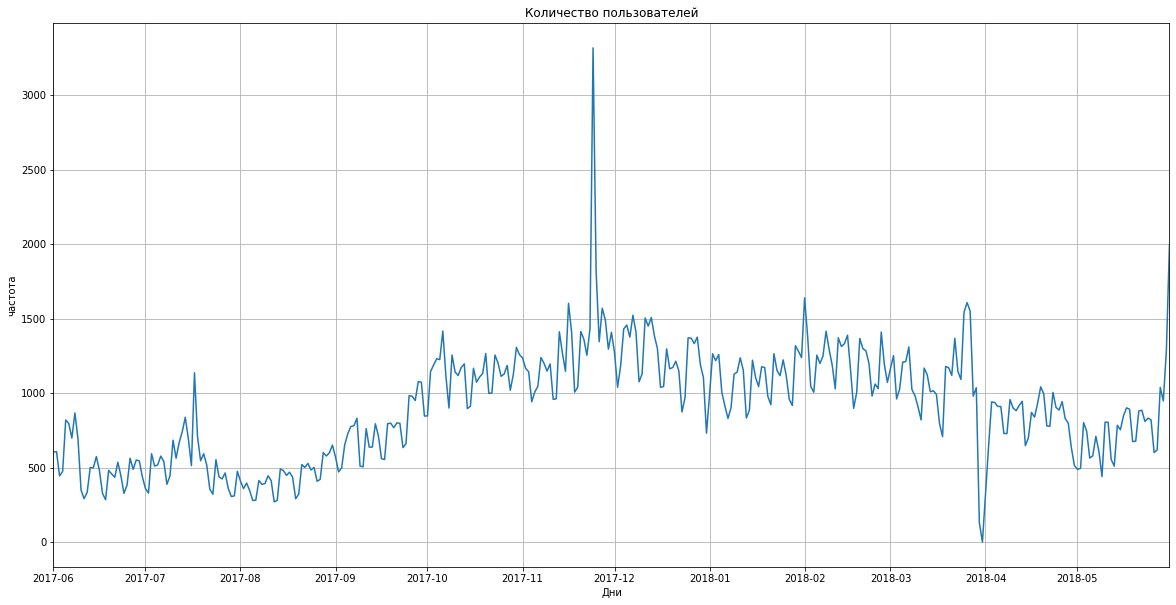

In [18]:
dau_graph = visits.groupby('date').agg({'uid': 'nunique'})
dau_graph.plot(grid=True, title='Количество пользователей', figsize=(20, 10),legend=False)
plt.xlabel('Дни')
plt.ylabel('частота')
plt.show()

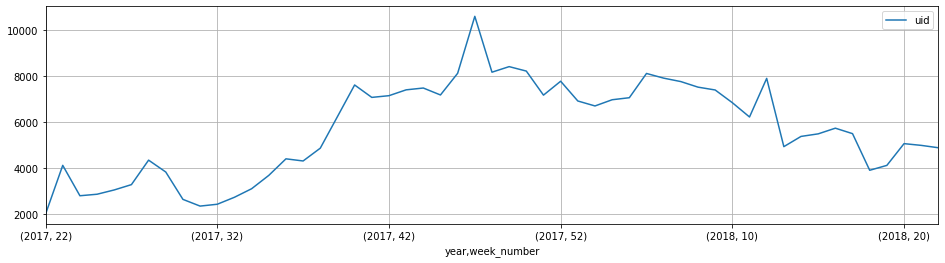

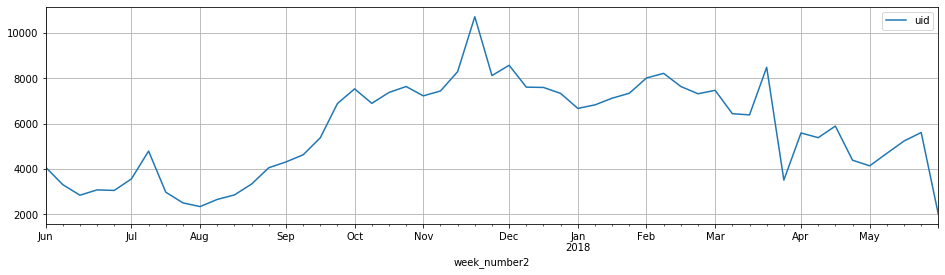

In [19]:
wau_graph = visits.copy()
wau_graph['week_number2']= wau_graph['start_ts'].astype('datetime64[W]')
wau_graph['year']=wau_graph['start_ts'].dt.year
ax1=wau_graph.groupby(['year','week_number']).agg({'uid': 'nunique'}).plot(figsize=(16, 4)).grid()
ax2=wau_graph.groupby(['week_number2']).agg({'uid': 'nunique'}).plot(figsize=(16, 4)).grid()
plt.show()  

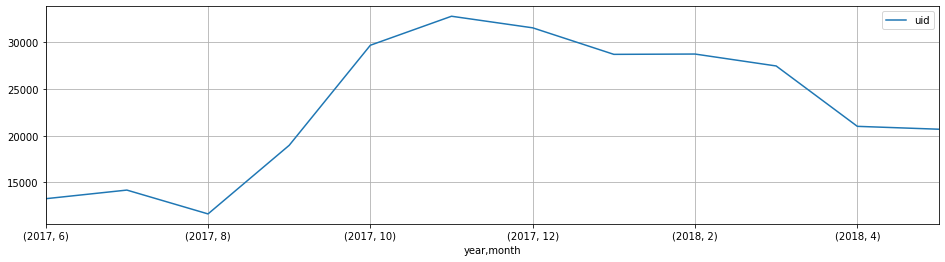

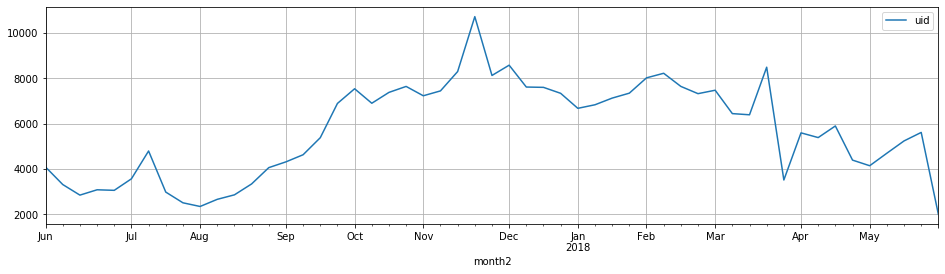

In [20]:
mau_graph = visits.copy()
mau_graph['month2']= mau_graph['start_ts'].astype('datetime64[W]')
mau_graph['year']=mau_graph['start_ts'].dt.year
ax1=mau_graph.groupby(['year','month']).agg({'uid': 'nunique'}).plot(figsize=(16, 4)).grid()
ax2=mau_graph.groupby(['month2']).agg({'uid': 'nunique'}).plot(figsize=(16, 4)).grid()
plt.show()   

###### Вывод по графикам.
* Есть что-то особенное в ноябре-декабре - может "Черная пятница".
* Упадок в апреле - скорее всего это затишье перед майскими праздниками и летним временем.
* Среднеактивные месяцы с января по апрель.
* Малоактивные с июня по август, но в июле есть "всплеск" активности.

#### Определите, сколько раз за день пользователи в среднем заходят на сайт. 

In [21]:
session_count = visits.groupby('date').agg({'uid': 'count'}).mean()
visits['session_duration_minunes'] = (visits['end_ts'] - visits['start_ts']).dt.total_seconds() / 60
visits = visits.query('session_duration_minunes >= 0')
print("Сессий в день: {0:.2f} ".format(session_count[0]))



Сессий в день: 987.36 


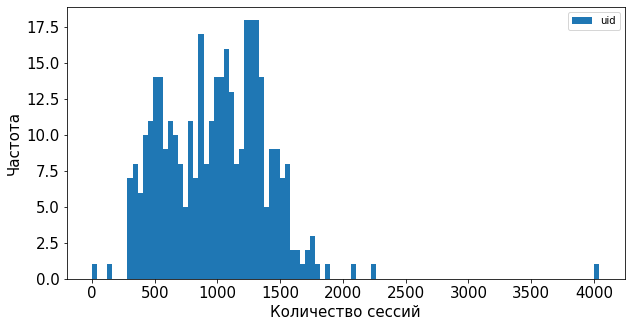

In [22]:
(visits
 .groupby('date')
 .agg({'uid':'count'})
 .plot(kind='hist', bins=100 ,figsize=(10, 5), fontsize=15)
)

plt.ylabel('Частота', fontsize=15)
plt.xlabel('Количество сессий',fontsize=15)
plt.show()

В среднем 987 сессий в день.

#### Исследуйте, сколько времени пользователи проводят на сайте.

In [23]:
visits['session_duration_minunes'].describe()

count    359398.000000
mean         10.717371
std          16.618420
min           0.000000
25%           2.000000
50%           5.000000
75%          14.000000
max         711.000000
Name: session_duration_minunes, dtype: float64

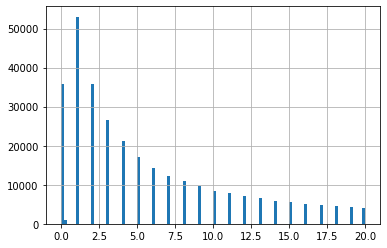

In [24]:
visits['session_duration_minunes'].hist(bins=100, range=(0, 20))

In [25]:
visits['session_duration_minunes'].mode()

0    1.0
dtype: float64

* В среднем показало 10 минут.
* Но в моде и видно на графике, что больше минутных сессий.

#### Рассчитайте Retention Rate, применяя когортный анализ. 

In [26]:
#создам новый датафрейм для первых посещений
first_visit = visits.groupby(['uid'])['start_ts'].min().reset_index()
first_visit.columns = ['uid', 'first_visit']
#добавлю значения нового датафрейма в таблицу с посещениями
visits = visits.merge(first_visit)
#добавлю временные показатели
visits['first_visit_month'] = visits['first_visit'].astype('datetime64[M]')
visits['visit_month'] = visits['start_ts'].astype('datetime64[M]')
visits['lifetime'] = (visits['visit_month'] - visits['first_visit_month']) / np.timedelta64(1, 'M')
visits['lifetime'] = visits['lifetime'].round().astype('int')
#сформирую когорты
cohort_visits = visits.groupby(['first_visit_month', 'lifetime']).agg({'uid': 'nunique'}).reset_index()
f_uid = cohort_visits[cohort_visits['lifetime'] == 0][['first_visit_month', 'uid']]
f_uid.columns = ['first_visit_month', 'f_uid']
#создам новый датафрейм по когортам
cohort_visits = cohort_visits.merge(f_uid)
cohort_visits['retention'] = cohort_visits['uid'] / cohort_visits['f_uid']
visits_retention_pivot = cohort_visits.pivot_table(index = 'first_visit_month', columns = 'lifetime', values = 'retention', aggfunc = 'sum')

visits_retention_pivot.mean() * 100

lifetime
0     100.000000
1       6.516660
2       4.633262
3       4.275990
4       4.059457
5       3.944383
6       3.695659
7       3.750912
8       3.546465
9       3.515906
10      3.406250
11      4.495060
dtype: float64

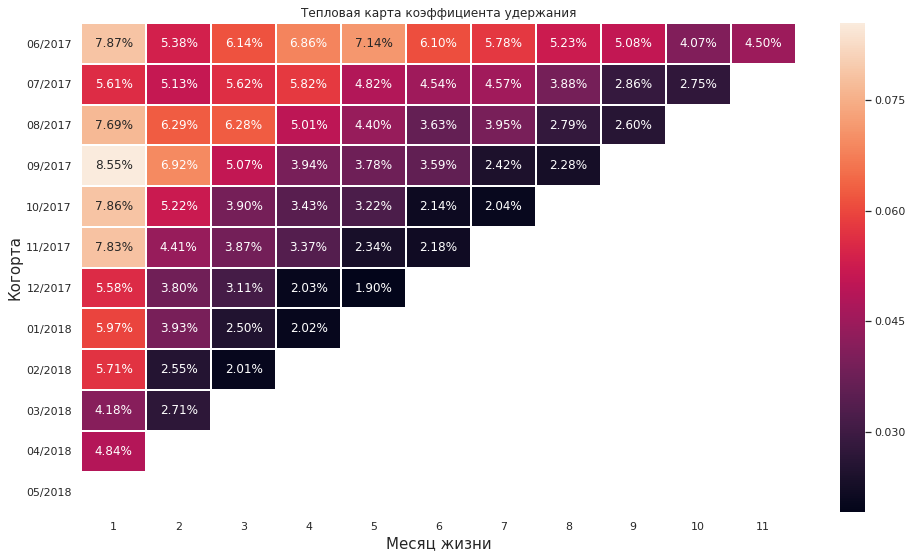

In [27]:
visits_retention_pivot.index = visits_retention_pivot.index.strftime("%m/%Y")
sns.set(style = 'white')
plt.figure(figsize = (16, 9))
plt.title('Тепловая карта коэффициента удержания')
sns.heatmap(visits_retention_pivot.iloc[:, 1:], annot=True, fmt='.2%', linewidths=1, linecolor='white')
plt.ylabel('Когорта', fontsize=15)
plt.xlabel('Месяц жизни',fontsize=15)
plt.show()

* Самый высокий коэффициент удержания у самой первой когорты - на 12 месяц своего существования коэффициент составляет 4.50%
* Низкие показатели, скорее всего, связаны с тем, что на сервисе Афиши долго не посидишь, существует эпизодичность интереса.

In [28]:
print(("Средний Retention Rate на второй месяц «жизни» когорт равен: {0:.1%}".format (visits_retention_pivot[1].mean())))

Средний Retention Rate на второй месяц «жизни» когорт равен: 6.5%


#### Вывод по Части 1:
* Высокая активность в ноябре-декабре-январе, далее идет спад (самая низкая точка это апрель).
    * Летом июль активный месяц.
* В среднем 987 сессий в день, но во временной перспективе бывает и до 4000.
* В среднем на сайте проводят до 10 минут.
* Самый высокий коэффициент удержания у самой первой когорты - на 12 месяц своего существования коэффициент составляет 4.50%
 

### Часть 2. Метрики электронной коммерции

#### Исследуйте, сколько времени в среднем проходит с момента первого посещения сайта до совершения покупки. 

In [29]:
first_visit = visits.groupby('uid').agg({'start_ts':'min'})\
                .rename(columns={'start_ts':'first_visit_date'})\
                .reset_index()
first_order = orders.groupby('uid').agg({'buy_ts':'min'})\
                .rename(columns={'purchase_ts':'first_purchase_date'})\
                .reset_index()
#объединю датафреймы по общему столбцу uid
data1 = first_visit.merge(first_order, on='uid', how='inner')
#data1.head(10)
data1['time_buy'] = (data1['buy_ts'] - data1['first_visit_date']).dt.seconds / 60
data1.head(10)

,uid,first_visit_date,buy_ts,time_buy
0,313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00,1382.0
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,0.0
2,2429014661409475,2017-10-11 17:14:00,2017-10-11 18:33:00,79.0
3,2464366381792757,2018-01-27 20:10:00,2018-01-28 15:54:00,1184.0
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00,0.0
5,3077748354309989,2018-03-03 12:08:00,2018-03-03 12:33:00,25.0
6,3605148382144603,2017-08-15 21:54:00,2017-09-21 20:56:00,1382.0
7,3753586865891862,2018-03-03 13:47:00,2018-03-03 13:50:00,3.0
8,4808417689019433,2018-01-09 23:10:00,2018-01-09 23:32:00,22.0
9,4992223027560440,2018-04-04 13:54:00,2018-04-04 13:54:00,0.0


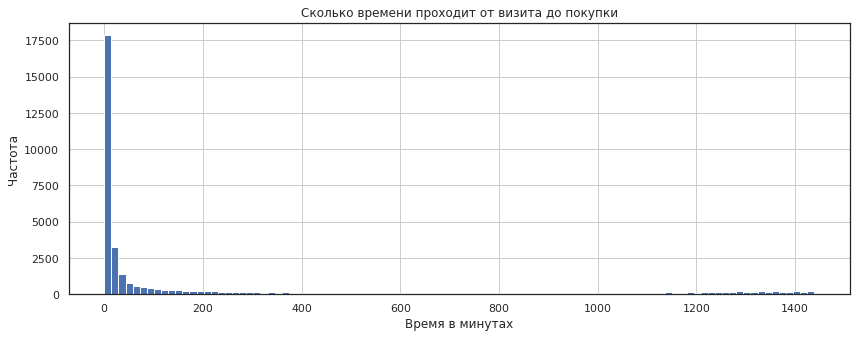

In [30]:
ax = data1['time_buy'].hist(bins=100, figsize=(14,5))
ax.set_xlabel('Время в минутах')
ax.set_ylabel('Частота')
ax.set_title('Сколько времени проходит от визита до покупки')
plt.show()

In [31]:
data1['time_buy'].describe()

count    36523.000000
mean       249.164691
std        429.742785
min          0.000000
25%          4.000000
50%         16.000000
75%        252.000000
max       1439.000000
Name: time_buy, dtype: float64

In [32]:
data1['time_buy'].mode()

0    1.0
dtype: float64

Итог:
* В среднем покупки делают через 249 минут.
* В моде сразу же в течении минуты.

#### Применяя когортный анализ или другой метод, рассчитайте среднее количество покупок на одного покупателя за определённый период

In [33]:
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')
orders_per_month = orders.groupby('order_month').agg({'revenue': 'count'}).rename(columns={'revenue':'n_purchases'})
#orders_per_month


orders_per_month=orders_per_month.reset_index()
first_orders = orders.groupby('uid').agg({'order_month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']
#first_orders.head(10) 

cohort_sizes = first_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']
cohort_sizes.head(12)



,first_order_month,n_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340
5,2017-11-01,4081
6,2017-12-01,4383
7,2018-01-01,3373
8,2018-02-01,3651
9,2018-03-01,3533


In [34]:
orders_per_month=pd.merge(orders_per_month, cohort_sizes, left_on='order_month', right_on='first_order_month')
orders_per_month['revenue_per_buyer']=orders_per_month['n_purchases']/orders_per_month['n_buyers']
print(("В среднем один пользователь совершает: {0:.1f} покупок в месяц ".format (orders_per_month['revenue_per_buyer'].mean())))

В среднем один пользователь совершает: 1.3 покупок в месяц 


In [35]:
print(("среднее количество покупок на одного покупателя за 6 месяцев: {0:.1f}".format (orders_per_month['revenue_per_buyer'][5].mean())))

среднее количество покупок на одного покупателя за 6 месяцев: 1.4


#### Рассчитайте средний чек.


In [36]:
#создам датафрейм data2 - объединю заказы и первые посещения
data2 = orders.merge(first_visit)
#добавлю столбцы с датами (дни, месяцы, недели)
data2['purchase_date'] = data2['buy_ts'].dt.date
data2['purchases_week'] = data2['buy_ts'].dt.week
data2['purchase_month'] = data2['buy_ts'].dt.month
#посчитаю количество покупок во временных показателях
purchases_per_day = data2.groupby('purchase_date')['uid'].count()
purchases_per_week = data2.groupby(['purchases_week'])['uid'].count()
purchases_per_month = data2.groupby(['purchase_month'])['uid'].count()
orders_count = pd.DataFrame()
data2['first_visit_date'] = pd.to_datetime(data2['first_visit_date'], format = '%Y-%m-%d')
data2.head(20)

,buy_ts,revenue,uid,order_month,first_visit_date,purchase_date,purchases_week,purchase_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01 00:09:00,2017-06-01,22,6
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01 00:14:00,2017-06-01,22,6
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01 00:25:00,2017-06-01,22,6
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01 00:14:00,2017-06-01,22,6
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01 07:31:00,2017-06-01,22,6
5,2017-06-01 08:43:00,0.18,10402394430196413321,2017-06-01,2017-06-01 08:43:00,2017-06-01,22,6
6,2017-06-01 08:54:00,1.83,12464626743129688638,2017-06-01,2017-06-01 08:51:00,2017-06-01,22,6
7,2017-06-05 14:30:00,7.33,12464626743129688638,2017-06-01,2017-06-01 08:51:00,2017-06-05,23,6
8,2017-06-01 09:22:00,1.22,3644482766749211722,2017-06-01,2017-06-01 09:22:00,2017-06-01,22,6
9,2017-06-02 12:44:00,0.85,3644482766749211722,2017-06-01,2017-06-01 09:22:00,2017-06-02,22,6


In [37]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50415 entries, 0 to 50414
Data columns (total 8 columns):
buy_ts              50415 non-null datetime64[ns]
revenue             50415 non-null float64
uid                 50415 non-null uint64
order_month         50415 non-null datetime64[ns]
first_visit_date    50415 non-null datetime64[ns]
purchase_date       50415 non-null object
purchases_week      50415 non-null int64
purchase_month      50415 non-null int64
dtypes: datetime64[ns](3), float64(1), int64(2), object(1), uint64(1)
memory usage: 3.5+ MB


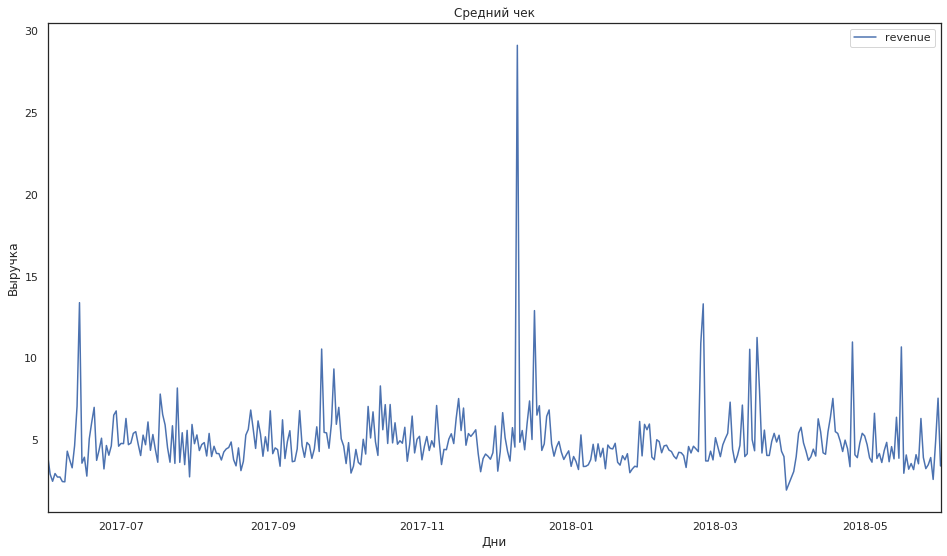

In [38]:
mean_purchase_by_date = data2.groupby('purchase_date').agg({'revenue': 'mean'})
ax = mean_purchase_by_date.plot(figsize=(16, 9))
plt.title('Средний чек') 
ax.set_xlabel('Дни')
ax.set_ylabel('Выручка')
plt.show()

Здесь же видно, что ноябрь-декабрь-январь самые активные месяцы: "Черная пятница", "Рождество", "Новый Год".

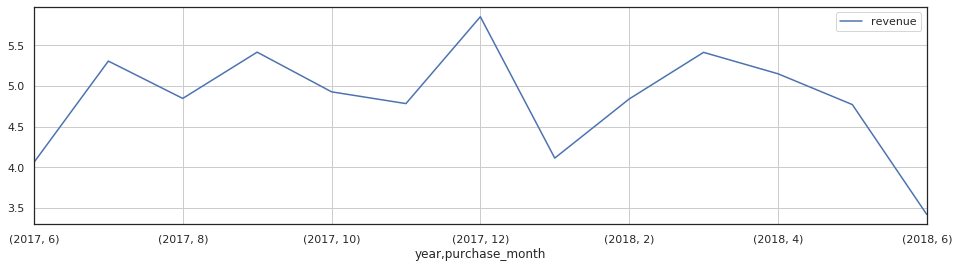

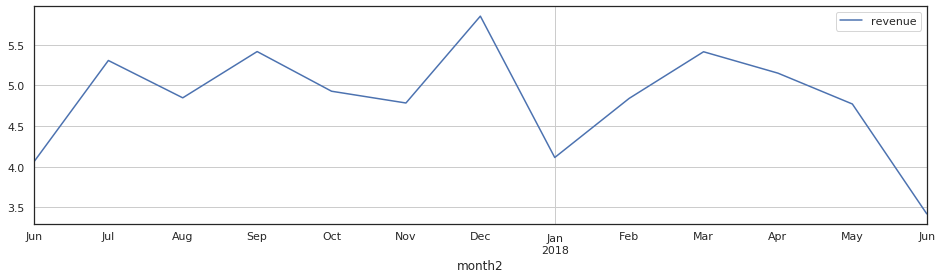

In [39]:
                   
                                        
mean_purchase_by_month = data2.copy()
mean_purchase_by_month['month2'] = mean_purchase_by_month['buy_ts'].astype('datetime64[M]')
mean_purchase_by_month['year'] = mean_purchase_by_month['buy_ts'].dt.year

ax1 = mean_purchase_by_month.groupby(['year','purchase_month']).agg({'revenue': 'mean'}).plot(figsize=(16, 4)).grid()
ax2 = mean_purchase_by_month.groupby(['month2']).agg({'revenue': 'mean'}).plot(figsize=(16, 4)).grid()
plt.show()                                        
                                        

* В месячной перспективе средний чек находится от 4 до 6.
* Рост замечается в феврале по май. Далее июньский упадок.
* Далее график отмечается положительным динамизмом: в июле есть положительная вершина -> в августе небольшой спад -> сентябрь-октябрь рост и спад -> с ноября по январь следующего года резкий рост

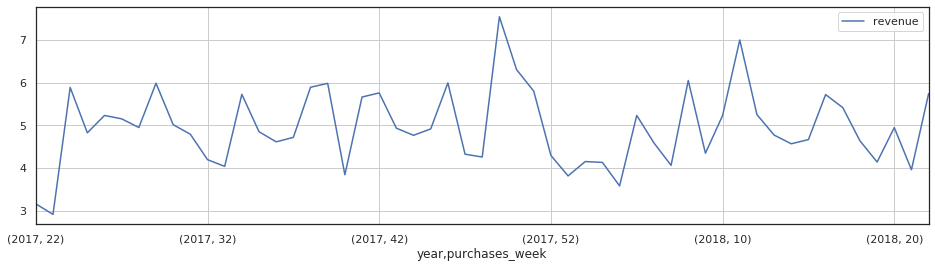

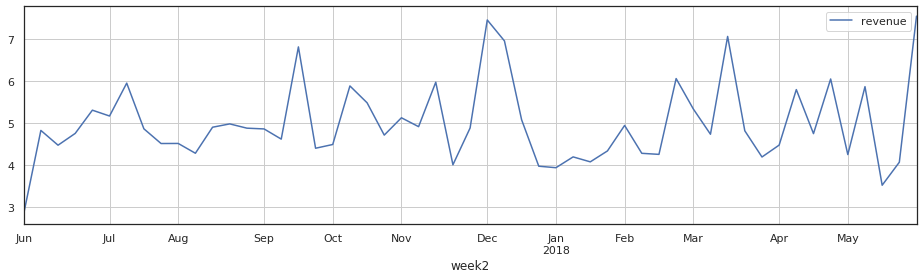

In [40]:
mean_purchase_by_week = data2.copy()
mean_purchase_by_week['week2'] = mean_purchase_by_week['buy_ts'].astype('datetime64[W]')
mean_purchase_by_week['year'] = mean_purchase_by_week['buy_ts'].dt.year

ax1 = mean_purchase_by_week.groupby(['year','purchases_week']).agg({'revenue': 'mean'}).plot(figsize=(16, 4)).grid()
ax2 = mean_purchase_by_week.groupby(['week2']).agg({'revenue': 'mean'}).plot(figsize=(16, 4)).grid()
plt.show()                                        
               


В недельной перспективе более детально видно на каких неделях есть положительные и отрицательные динамики в месяцах.

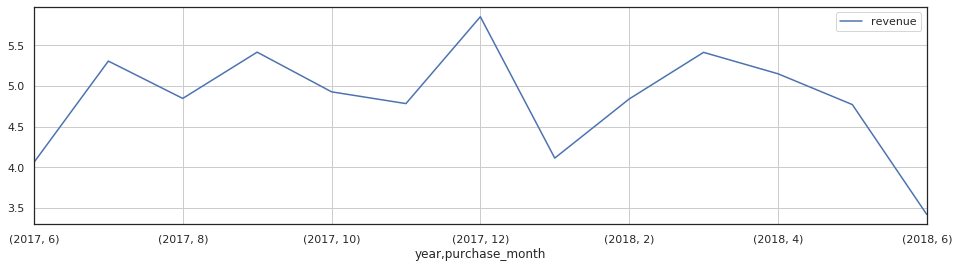

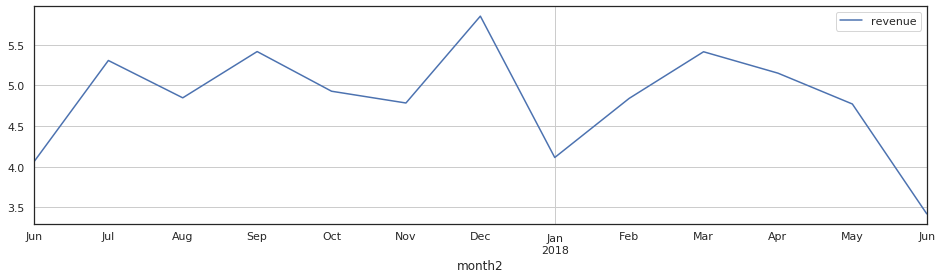

In [41]:
# код ревьюера:
tmp = data2.copy()
tmp['month2'] = tmp['buy_ts'].astype('datetime64[M]')
tmp['year'] = tmp['buy_ts'].dt.year

ax1 = tmp.groupby(['year','purchase_month']).agg({'revenue': 'mean'}).plot(figsize=(16, 4)).grid()
ax2 = tmp.groupby(['month2']).agg({'revenue': 'mean'}).plot(figsize=(16, 4)).grid()
plt.show()

Мне кажется, что скидки побуждают людей тратить больше, поэтому такой бум на графике

In [42]:
data2['revenue'].describe()

count    50415.000000
mean         4.999647
std         21.818359
min          0.000000
25%          1.220000
50%          2.500000
75%          4.890000
max       2633.280000
Name: revenue, dtype: float64

В итоге: средний чек составляет 5, т.к. цифры после запятой = .999647.

#### Выясните, как меняется LTV на покупателя по когортам.

In [43]:
#Нужно будет объединить датафреймы по первым покупкам и размерам когорт
new_orders = pd.merge(orders,first_orders, on='uid')
new_orders.head(10)

,buy_ts,revenue,uid,order_month,first_order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01
5,2017-06-01 08:43:00,0.18,10402394430196413321,2017-06-01,2017-06-01
6,2017-06-01 08:54:00,1.83,12464626743129688638,2017-06-01,2017-06-01
7,2017-06-05 14:30:00,7.33,12464626743129688638,2017-06-01,2017-06-01
8,2017-06-01 09:22:00,1.22,3644482766749211722,2017-06-01,2017-06-01
9,2017-06-02 12:44:00,0.85,3644482766749211722,2017-06-01,2017-06-01


In [44]:
#сделаю датафрейм с когортами:
cohorts = new_orders.groupby(['first_order_month','order_month']).agg({'revenue': 'sum'}).reset_index()
cohorts.head(10)

,first_order_month,order_month,revenue
0,2017-06-01,2017-06-01,9557.49
1,2017-06-01,2017-07-01,981.82
2,2017-06-01,2017-08-01,885.34
3,2017-06-01,2017-09-01,1931.30
4,2017-06-01,2017-10-01,2068.58
5,2017-06-01,2017-11-01,1487.92
6,2017-06-01,2017-12-01,1922.74
7,2017-06-01,2018-01-01,1176.56
8,2017-06-01,2018-02-01,1119.15
9,2017-06-01,2018-03-01,1225.51


In [45]:
#создам датафрейм data4 через объединение датафреймов когорт и размеров когорт
data4 = pd.merge(cohort_sizes, cohorts, on='first_order_month')
#data4.head(5)
#добавлю возраст когорот 
data4['age'] = (data4['order_month'] - data4['first_order_month']) / np.timedelta64(1, 'M')
data4['age'] = data4['age'].round().astype('int')
data4.head(10)

,first_order_month,n_buyers,order_month,revenue,age
0,2017-06-01,2023,2017-06-01,9557.49,0
1,2017-06-01,2023,2017-07-01,981.82,1
2,2017-06-01,2023,2017-08-01,885.34,2
3,2017-06-01,2023,2017-09-01,1931.30,3
4,2017-06-01,2023,2017-10-01,2068.58,4
5,2017-06-01,2023,2017-11-01,1487.92,5
6,2017-06-01,2023,2017-12-01,1922.74,6
7,2017-06-01,2023,2018-01-01,1176.56,7
8,2017-06-01,2023,2018-02-01,1119.15,8
9,2017-06-01,2023,2018-03-01,1225.51,9


In [46]:
#Приступлю к когортному анализу
margin_rate = 1

data4['gp'] = data4['revenue'] * margin_rate
data4['age'] = (data4['order_month'] - data4['first_order_month']) / np.timedelta64(1, 'M')
data4['age'] = data4['age'].round().astype('int')
data4['ltv'] = data4['gp'] / data4['n_buyers']
output = data4.pivot_table(index="first_order_month",
                columns="age",
                values="ltv",
                aggfunc='mean')

output.fillna('') 

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.724414,0.485329,0.437637,0.954671,1.02253,0.735502,0.95044,0.581592,0.553213,0.605788,0.571261,0.256856
2017-07-01,6.010218,0.335211,0.623531,0.358976,0.176791,0.156048,0.120208,0.14182,0.161232,0.147145,0.155673,
2017-08-01,5.276518,0.471993,0.458482,0.391277,0.494051,0.28354,0.210664,0.405007,0.292212,0.187978,,
2017-09-01,5.644529,1.11759,0.52093,3.97579,0.400558,0.647067,0.701608,0.24315,0.184006,,,
2017-10-01,5.003733,0.535763,0.191394,0.157145,0.15156,0.120362,0.0848157,0.11547,,,,
2017-11-01,5.154683,0.399233,0.199556,0.324952,0.148013,0.053879,0.114928,,,,,
2017-12-01,4.738191,0.260374,0.925097,1.06527,0.31293,0.338047,,,,,,
2018-01-01,4.135636,0.294758,0.304281,0.142778,0.0626979,,,,,,,
2018-02-01,4.156987,0.278274,0.0785155,0.0741441,,,,,,,,


In [47]:
data4.head(10)

,first_order_month,n_buyers,order_month,revenue,age,gp,ltv
0,2017-06-01,2023,2017-06-01,9557.49,0,9557.49,4.724414
1,2017-06-01,2023,2017-07-01,981.82,1,981.82,0.485329
2,2017-06-01,2023,2017-08-01,885.34,2,885.34,0.437637
3,2017-06-01,2023,2017-09-01,1931.30,3,1931.30,0.954671
4,2017-06-01,2023,2017-10-01,2068.58,4,2068.58,1.022531
5,2017-06-01,2023,2017-11-01,1487.92,5,1487.92,0.735502
6,2017-06-01,2023,2017-12-01,1922.74,6,1922.74,0.950440
7,2017-06-01,2023,2018-01-01,1176.56,7,1176.56,0.581592
8,2017-06-01,2023,2018-02-01,1119.15,8,1119.15,0.553213
9,2017-06-01,2023,2018-03-01,1225.51,9,1225.51,0.605788


In [48]:
data4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79 entries, 0 to 78
Data columns (total 7 columns):
first_order_month    79 non-null datetime64[ns]
n_buyers             79 non-null int64
order_month          79 non-null datetime64[ns]
revenue              79 non-null float64
age                  79 non-null int64
gp                   79 non-null float64
ltv                  79 non-null float64
dtypes: datetime64[ns](2), float64(3), int64(2)
memory usage: 4.9 KB


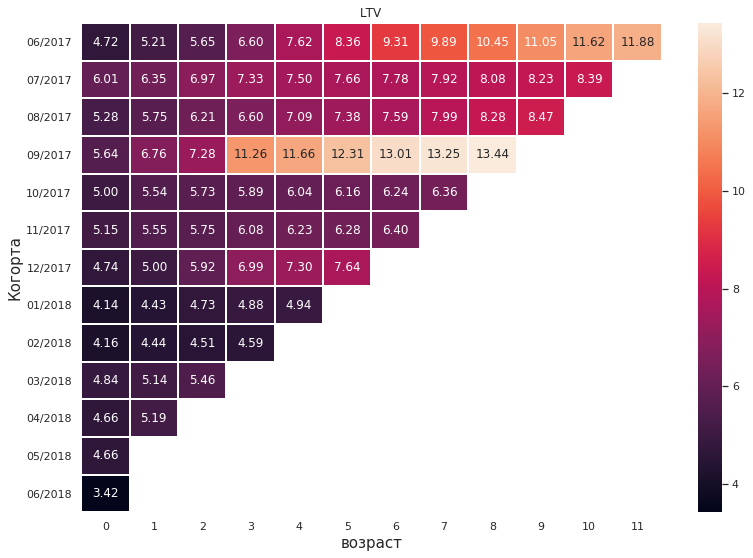

In [49]:
output.index = output.index.strftime("%m/%Y")
sns.set(style='white')
plt.figure(figsize=(13, 9))
sns.heatmap(output.cumsum(axis = 1), annot=True, fmt='.2f', linewidths=1);
plt.title('LTV')
plt.ylabel('Когорта', fontsize=15)
plt.xlabel('возраст',fontsize=15)
plt.show()

In [50]:
print(("Средний LTV по когортам за 6 месяцев равен: {0:.1f}".format (output.cumsum(axis=1)[5].mean())))

Средний LTV по когортам за 6 месяцев равен: 8.0


* Первые три когорты 2017 года были самыми активными и качественными - сюда же можно отнести и 4 когороту, но с 3 периода - их LTV заметно отличается от всех.
* Когорта №1 самая активная - каждый месяц есть активности и хорошие данные.

### Итог по Части 2.
1) В среднем покупки делают через 249 минут.
    * В моде сразу же в течении минуты.
2) В среднем один пользователь совершает: 1.3 покупок в месяц 

3) В месячной перспективе средний чек находится от 5 до 6.
    * ноябрь-декабрь-январь самые активные месяцы: "Черная пятница", "Рождество", "Новый Год".
4) Первые три когорты 2017 года были самыми активными и качественными - сюда же можно отнести и 4 когороту, но с 3 периода 
    * Средний LTV по когортам за 6 месяцев равен: 8.0
    

### Часть 3. Маркетинговые метрики

#### Посчитайте общую сумму расходов на маркетинг. Выясните, как траты распределены по источникам. Визуализируйте изменения метрик во времени

In [51]:
source_costs=costs.groupby('source_id').agg({'costs':'sum'}).reset_index()
source_costs

,source_id,costs
0,1,20833.27
1,2,42806.04
2,3,141321.63
3,4,61073.60
4,5,51757.10
5,9,5517.49
6,10,5822.49


In [52]:
print('Всего на маркетинг потратили:', source_costs['costs'].sum())

Всего на маркетинг потратили: 329131.6199999999


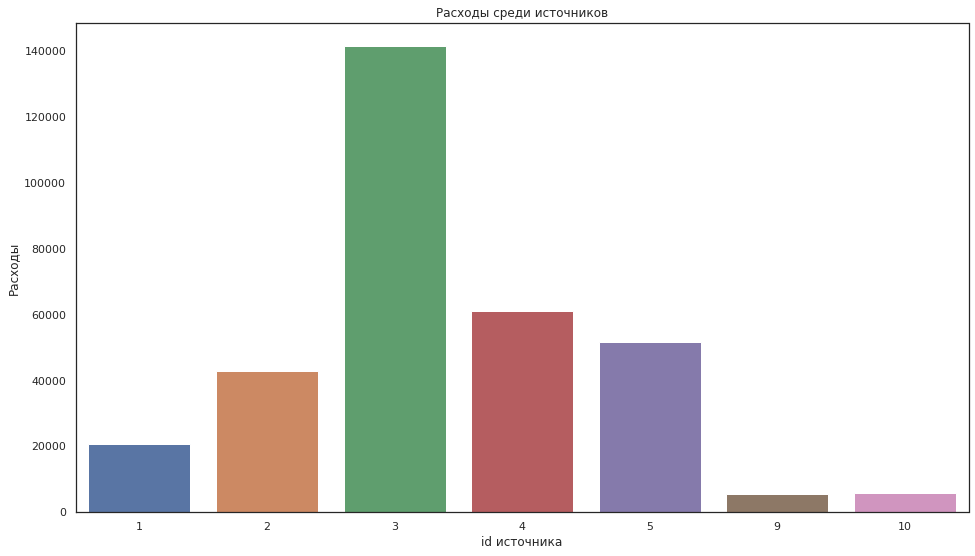

In [53]:
plt.figure(figsize = (16, 9))
ax = sns.barplot(x='source_id', y='costs', data=source_costs)
plt.title('Расходы среди источников')
ax.set_xlabel('id источника')
ax.set_ylabel('Расходы')
plt.show()

Больше всего потратили на 3 источник, потом на 4 и 5

In [54]:
costs['costs_month'] = costs['date'].astype('datetime64[M]')
costs_by_month = costs.groupby('costs_month')['costs'].sum().reset_index()
costs_by_month

,costs_month,costs
0,2017-06-01,18015.00
1,2017-07-01,18240.59
2,2017-08-01,14790.54
3,2017-09-01,24368.91
4,2017-10-01,36322.88
5,2017-11-01,37907.88
6,2017-12-01,38315.35
7,2018-01-01,33518.52
8,2018-02-01,32723.03
9,2018-03-01,30415.27


In [55]:
costs_by_month['costs_month'] = pd.to_datetime(costs_by_month['costs_month'], format = '%Y-%m-%d')

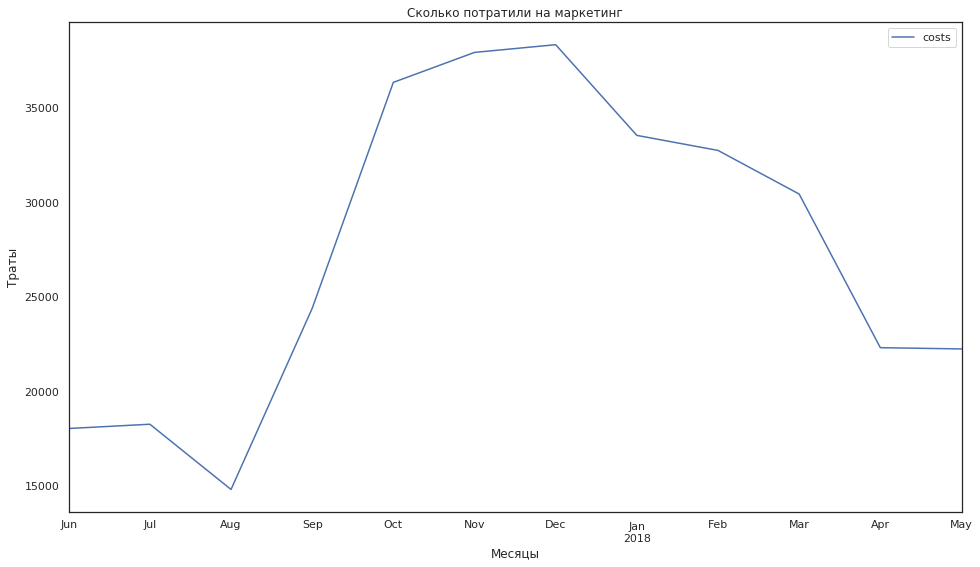

In [56]:
costs_by_month_graf = costs_by_month.groupby('costs_month').agg({'costs': 'mean'})
ax = costs_by_month_graf.plot(figsize=(16, 9))
plt.title('Сколько потратили на маркетинг') 
ax.set_xlabel('Месяцы')
ax.set_ylabel('Траты')
plt.show()

Самыми затратными месяцами были сенью и зимой - мне кажется, что это сопряженные месяца - к новому году готовятся с осени. как видно тут динамика роста повышается с октября, а заканчивается уже в январе, т.к. сезон прошел.

#### Рассчитайте средний CAC на одного покупателя для всего проекта и для каждого источника трафика.

In [57]:
#Как в тренажере создам единый датафрейм:
report_new = pd.merge(data4, costs_by_month, left_on = 'first_order_month', right_on='costs_month')
report_new['cac'] = report_new['costs'] / report_new['n_buyers']
report_new.head() 

,first_order_month,n_buyers,order_month,revenue,age,gp,ltv,costs_month,costs,cac
0,2017-06-01,2023,2017-06-01,9557.49,0,9557.49,4.724414,2017-06-01,18015.0,8.905091
1,2017-06-01,2023,2017-07-01,981.82,1,981.82,0.485329,2017-06-01,18015.0,8.905091
2,2017-06-01,2023,2017-08-01,885.34,2,885.34,0.437637,2017-06-01,18015.0,8.905091
3,2017-06-01,2023,2017-09-01,1931.30,3,1931.30,0.954671,2017-06-01,18015.0,8.905091
4,2017-06-01,2023,2017-10-01,2068.58,4,2068.58,1.022531,2017-06-01,18015.0,8.905091


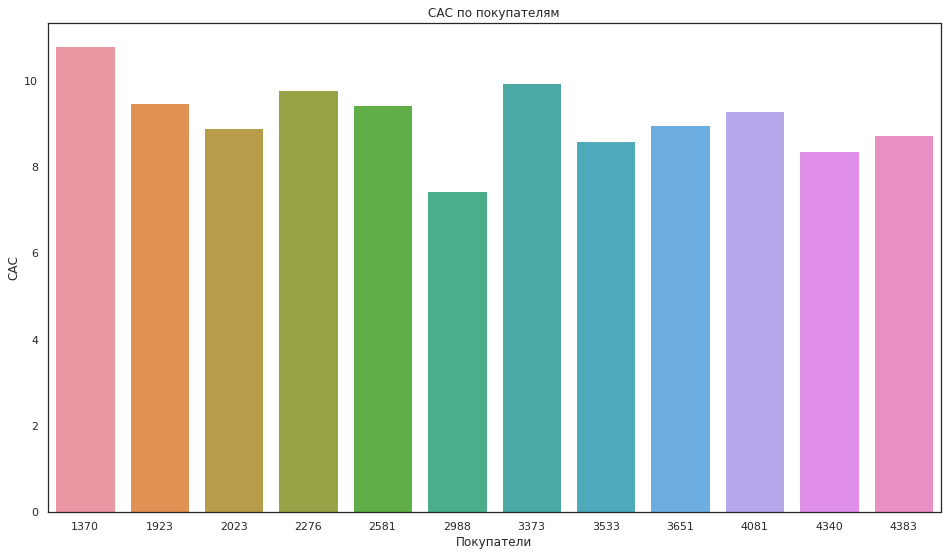

In [58]:
plt.figure(figsize = (16, 9))
ax = sns.barplot(x="n_buyers", y="cac", data=report_new)
plt.title('CAC по покупателям')
ax.set_xlabel('Покупатели')
ax.set_ylabel('CAC')
plt.show()

In [59]:
#сколько клиентов пришло с каждого источника
visits_by_source = visits.query('start_ts == first_visit')
customers_by_source = (orders.merge(visits_by_source, on='uid', how='inner')).groupby('source_id').agg({'uid':'nunique'})\
                        .rename(columns={'uid':'customers'})
customers_by_source

,customers
source_id,
1,2899
2,3506
3,10473
4,10296
5,6931
7,1
9,1088
10,1329


In [60]:
#создам новый фрейм для подсчета CAC для типов источников.
costs_by_source = costs.groupby('source_id').agg({'costs':'sum'})
cac = customers_by_source.join(costs_by_source).reset_index()
cac = cac.fillna(0)
cac['cac'] = cac['costs'] / cac['customers']
cac.sort_values('cac', ascending = False)
cac

,source_id,customers,costs,cac
0,1,2899,20833.27,7.186364
1,2,3506,42806.04,12.209367
2,3,10473,141321.63,13.493901
3,4,10296,61073.60,5.931779
4,5,6931,51757.10,7.467479
5,7,1,0.00,0.000000
6,9,1088,5517.49,5.071222
7,10,1329,5822.49,4.381106


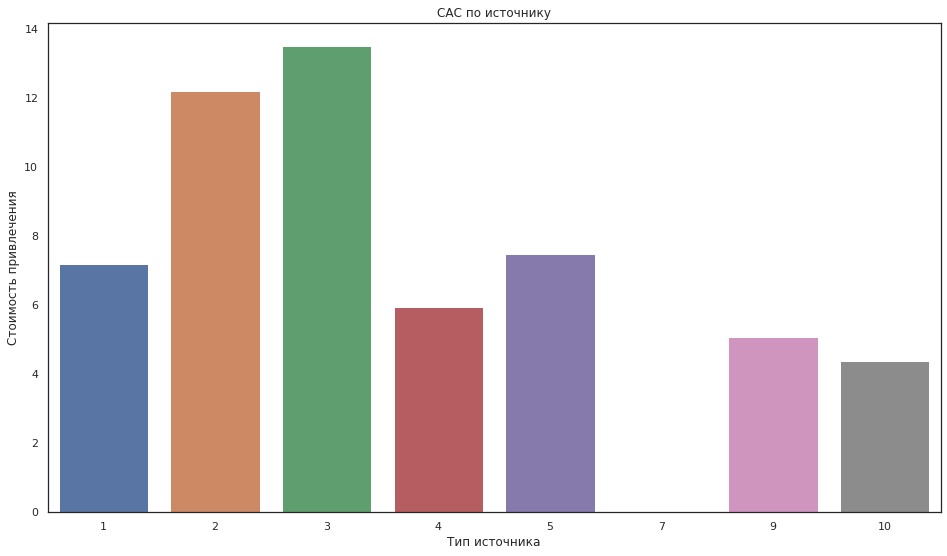

In [61]:
plt.figure(figsize = (16, 9))
ax = sns.barplot(x="source_id", y="cac", data=cac)
plt.title('CAC по источнику')
ax.set_xlabel('Тип источника')
ax.set_ylabel('Стоимость привлечения')
plt.show()

Здесь видно, что 3 тип источника в лидерах, далее идет 2, и замыкает тройку лидеров 5. 7 - совсем не использовался.

####  Рассчитайте ROMI по когортам в разрезе источников. 

In [62]:
report_new['romi'] = report_new['ltv'] / report_new['cac']
report_new.head(10)

,first_order_month,n_buyers,order_month,revenue,age,gp,ltv,costs_month,costs,cac,romi
0,2017-06-01,2023,2017-06-01,9557.49,0,9557.49,4.724414,2017-06-01,18015.0,8.905091,0.530530
1,2017-06-01,2023,2017-07-01,981.82,1,981.82,0.485329,2017-06-01,18015.0,8.905091,0.054500
2,2017-06-01,2023,2017-08-01,885.34,2,885.34,0.437637,2017-06-01,18015.0,8.905091,0.049145
3,2017-06-01,2023,2017-09-01,1931.30,3,1931.30,0.954671,2017-06-01,18015.0,8.905091,0.107205
4,2017-06-01,2023,2017-10-01,2068.58,4,2068.58,1.022531,2017-06-01,18015.0,8.905091,0.114825
5,2017-06-01,2023,2017-11-01,1487.92,5,1487.92,0.735502,2017-06-01,18015.0,8.905091,0.082593
6,2017-06-01,2023,2017-12-01,1922.74,6,1922.74,0.950440,2017-06-01,18015.0,8.905091,0.106730
7,2017-06-01,2023,2018-01-01,1176.56,7,1176.56,0.581592,2017-06-01,18015.0,8.905091,0.065310
8,2017-06-01,2023,2018-02-01,1119.15,8,1119.15,0.553213,2017-06-01,18015.0,8.905091,0.062123
9,2017-06-01,2023,2018-03-01,1225.51,9,1225.51,0.605788,2017-06-01,18015.0,8.905091,0.068027


In [63]:
output = report_new.pivot_table(
    index='first_order_month', columns='age', values='romi', aggfunc='mean'
)

output.cumsum(axis=1).round(2) 

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,0.53,0.59,0.63,0.74,0.86,0.94,1.05,1.11,1.17,1.24,1.31,1.33
2017-07-01,0.63,0.67,0.73,0.77,0.79,0.81,0.82,0.84,0.85,0.87,0.88,NaN
2017-08-01,0.49,0.53,0.57,0.61,0.66,0.68,0.70,0.74,0.77,0.78,NaN,NaN
2017-09-01,0.60,0.72,0.77,1.19,1.23,1.30,1.38,1.40,1.42,NaN,NaN,NaN
2017-10-01,0.60,0.66,0.68,0.70,0.72,0.74,0.75,0.76,NaN,NaN,NaN,NaN
2017-11-01,0.55,0.60,0.62,0.65,0.67,0.68,0.69,NaN,NaN,NaN,NaN,NaN
2017-12-01,0.54,0.57,0.68,0.80,0.84,0.87,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,0.42,0.45,0.48,0.49,0.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,0.46,0.49,0.50,0.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
output.cumsum(axis=1).mean(axis=0) 

age
0     0.540816
1     0.581985
2     0.631069
3     0.719740
4     0.782946
5     0.859876
6     0.896819
7     0.969951
8     1.053871
9     0.964488
10    1.094658
11    1.333982
dtype: float64

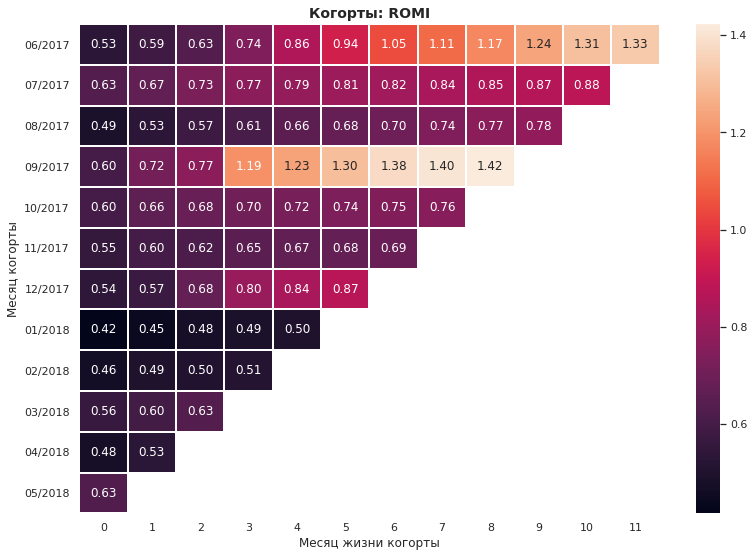

In [65]:
output.index = output.index.strftime("%m/%Y")
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Когорты: ROMI', size=14, weight = 'bold')
ax=sns.heatmap(output.cumsum(axis=1), annot=True, fmt='.2f', linewidths=1)
ax.set_ylabel('Месяц когорты')
ax.set_xlabel('Месяц жизни когорты');

Самые прибыльные когорты: 06.2017 и 09.2017

Теперь нужно найти ROMI по источникам

1) Найду рекламный источник для первых визитов

2) Найду сумму выручки по каждому источнику

3) Объединю таблицы и посчитаю роми

In [66]:
uid_source = visits.groupby(['uid'])['source_id'].min()
uid_source.name = 'uid_source'
uid_source = orders.join(uid_source,on='uid')
uid_source.head()

,buy_ts,revenue,uid,order_month,uid_source
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,3


In [67]:
sourse_profit=uid_source.groupby(['uid_source'])['revenue'].sum().reset_index()
sourse_profit

,uid_source,revenue
0,1,101631.38
1,2,43123.74
2,3,43354.82
3,4,36705.84
4,5,22919.80
5,7,1.22
6,9,1874.18
7,10,2446.22


In [68]:
source_romi = cac.merge(sourse_profit, left_on='source_id', right_on='uid_source')
source_romi['romi']=source_romi['revenue']/source_romi['costs']
source_romi

,source_id,customers,costs,cac,uid_source,revenue,romi
0,1,2899,20833.27,7.186364,1,101631.38,4.878321
1,2,3506,42806.04,12.209367,2,43123.74,1.007422
2,3,10473,141321.63,13.493901,3,43354.82,0.306781
3,4,10296,61073.60,5.931779,4,36705.84,0.601010
4,5,6931,51757.10,7.467479,5,22919.80,0.442834
5,7,1,0.00,0.000000,7,1.22,inf
6,9,1088,5517.49,5.071222,9,1874.18,0.339680
7,10,1329,5822.49,4.381106,10,2446.22,0.420133


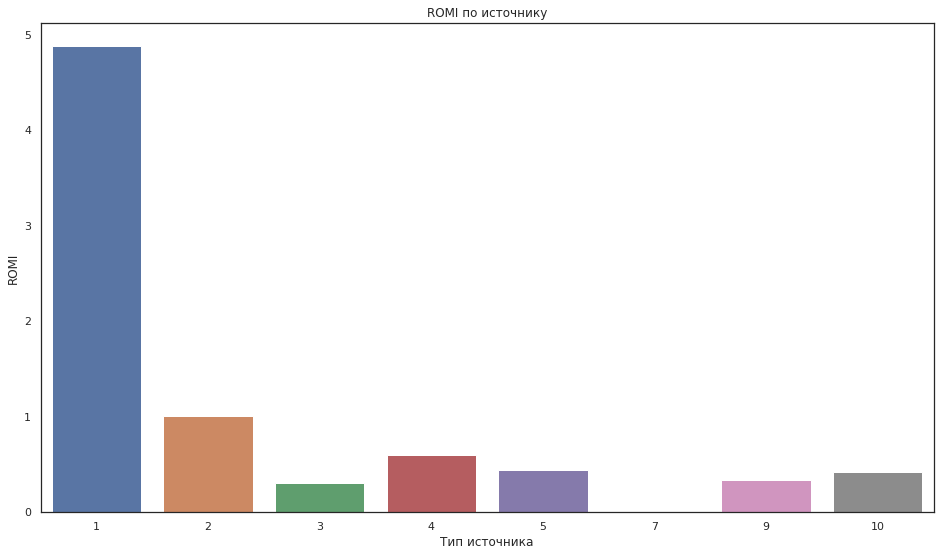

In [69]:
plt.figure(figsize = (16, 9))
ax = sns.barplot(x="source_id", y="romi", data=source_romi)
plt.title('ROMI по источнику')
ax.set_xlabel('Тип источника')
ax.set_ylabel('ROMI')
plt.show()

Лидер здесь источник под номером 1, далее идет источник номер 2.

In [70]:
# ШАГ 1: здесь все нормально - используем уже подготовленную таблицу с первой покупкой:
data_general = data2.merge(first_orders, on = 'uid')

# ШАГ 2: далее ты определил первый источник - в целом верно, хотя надеждее использовать 'start_ts' вот так:

# visits = visits.sort_values(by='first_visit')
# first_source = visits.groupby('uid')['source_id'].first().reset_index()

first_source = visits.sort_values(by = 'start_ts').groupby('uid')['source_id'].first().reset_index()

# ШАГ 3: тут тоже все верно:
orders_with_sources = data_general.merge(first_source, on='uid')

# ШАГ 4: Далее определяем размер когорты по первому месяцу покупки:
customers_by_sources = (orders_with_sources
        # у тебя была такая группировка, на мой взгляд тут много лишнего, предлагаю оставить так,
        # поскольку мы считаем когорты по месяцам - и нам нужно знать количество уников в первый месяц когорты:             
        # .groupby(['first_visit_date', 'first_order_month', 'purchase_date', 'source_id'])                
        .groupby(['source_id', 'first_order_month'])                
        .agg({'uid': 'nunique'})
        .reset_index()
    )

# ШАГ 5: Далее определяем прибыль когорты по источнику в месяц, тут все верно, но я сделаю в другой последовательности:
        # и счетать мы будем по первому месяцу покупки,
revenue_by_sources = (orders_with_sources
        .groupby(['first_order_month', 'order_month', 'source_id'])
        .agg({'revenue': 'sum'})
        .reset_index())

# ШАГ 6: сделаем сводную таблицу - логика тоже правильная, только немного скорректируем под наши новые столбцы:
report_source = revenue_by_sources.merge(customers_by_sources, on=['first_order_month', 'source_id'])

# ШАГ 7: подсчитаем затраты, чтобы все было вместе, возьму твой код, но группировать буду по месяцу - когорты месячные:
costs_for_cac = (costs
                 .groupby(['costs_month', 'source_id'])
                 .agg({'costs': 'sum'})
                 .reset_index())

# ШАГ 8 соединим все вместе, объединять будем по первому месяцу: 
romi_report_source = report_source.merge(costs_for_cac, left_on=['first_order_month', 'source_id'], \
                                              right_on=['costs_month','source_id'])

# ШАГ 9 проведем расчет возраста - возьму твой код, но другие определения первого месяца и месяца покупки: 
romi_report_source['age'] = (romi_report_source['order_month'] - romi_report_source['first_order_month']) / np.timedelta64(1, 'M')
romi_report_source['age'] = romi_report_source['age'].round().astype('int')

# теперь данные готовы для рассчетов, далее их можно обернуть в функцию - см следующую ячеку:
#romi_report_source.head()
romi_report_source['ltv'] = romi_report_source['revenue'] / romi_report_source['uid']
romi_report_source['cac'] = romi_report_source['costs'] / romi_report_source['uid']
romi_report_source['roi'] = romi_report_source['ltv'] / romi_report_source['cac']
romi_report_source    

,first_order_month,order_month,source_id,revenue,uid,costs_month,costs,age,ltv,cac,roi
0,2017-06-01,2017-06-01,1,1378.70,190,2017-06-01,1125.61,0,7.256316,5.924263,1.224847
1,2017-06-01,2017-07-01,1,414.98,190,2017-06-01,1125.61,1,2.184105,5.924263,0.368671
2,2017-06-01,2017-08-01,1,419.43,190,2017-06-01,1125.61,2,2.207526,5.924263,0.372625
3,2017-06-01,2017-09-01,1,714.24,190,2017-06-01,1125.61,3,3.759158,5.924263,0.634536
4,2017-06-01,2017-10-01,1,811.20,190,2017-06-01,1125.61,4,4.269474,5.924263,0.720676
...,...,...,...,...,...,...,...,...,...,...,...
509,2018-05-01,2018-05-01,3,3256.54,844,2018-05-01,9411.42,0,3.858460,11.150972,0.346020
510,2018-05-01,2018-05-01,4,3802.91,804,2018-05-01,4214.21,0,4.729988,5.241555,0.902402
511,2018-05-01,2018-05-01,5,2094.04,497,2018-05-01,3669.56,0,4.213360,7.383421,0.570652
512,2018-05-01,2018-05-01,9,223.05,60,2018-05-01,362.17,0,3.717500,6.036167,0.615871


In [71]:
romi_heatmap = romi_report_source.pivot_table(
    index='source_id', columns='age', values='roi', aggfunc='mean'
)

romi_heatmap.cumsum(axis=1).round(2) 

age,0,1,2,3,4,5,6,7,8,9,10,11
source_id,,,,,,,,,,,,
1,0.89,1.05,1.22,1.38,1.51,1.60,1.70,1.89,2.10,2.28,2.45,2.73
2,0.55,0.68,0.80,0.95,1.03,1.10,1.17,1.23,1.27,1.30,1.39,1.43
3,0.34,0.36,0.37,0.38,0.39,0.40,0.40,0.41,0.41,0.42,0.42,0.42
4,0.76,0.79,0.81,0.84,0.87,0.91,0.98,0.99,1.01,1.05,1.12,1.13
5,0.66,0.71,0.75,1.06,1.12,1.19,1.23,1.27,1.31,1.37,1.38,1.40
9,0.77,0.83,0.91,0.98,1.03,1.07,1.13,1.18,1.28,1.31,1.32,NaN
10,0.73,0.75,0.76,0.78,0.79,0.80,0.81,0.82,0.82,0.84,NaN,NaN


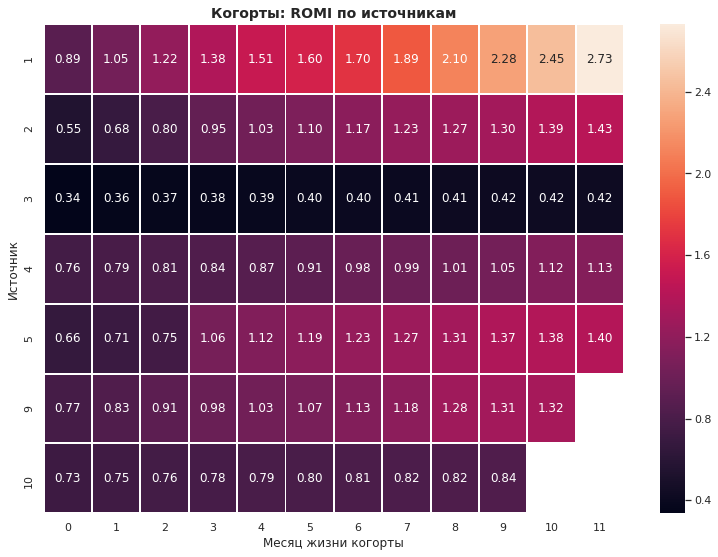

In [72]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Когорты: ROMI по источникам', size=14, weight = 'bold')
ax=sns.heatmap(romi_heatmap.cumsum(axis=1), annot=True, fmt='.2f', linewidths=1)
ax.set_ylabel('Источник')
ax.set_xlabel('Месяц жизни когорты');

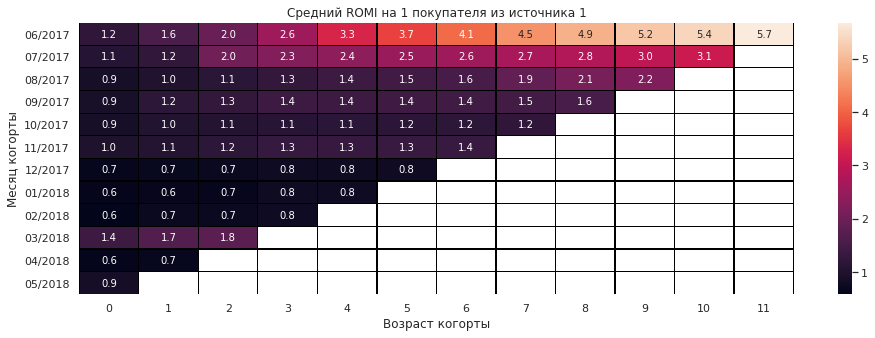

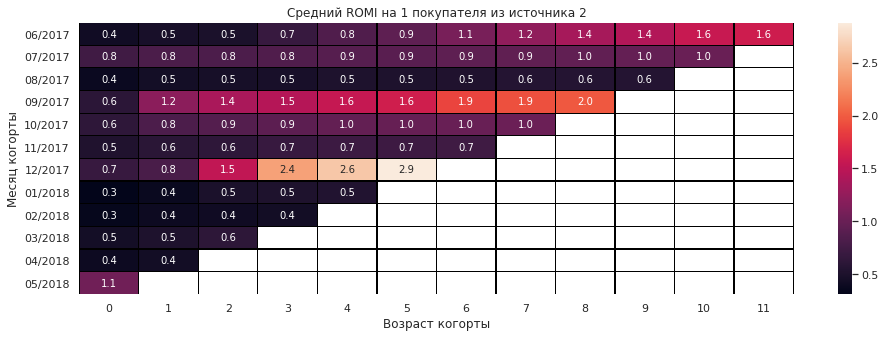

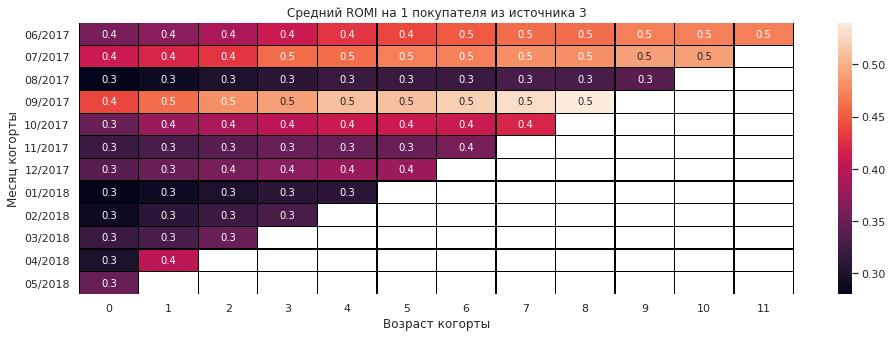

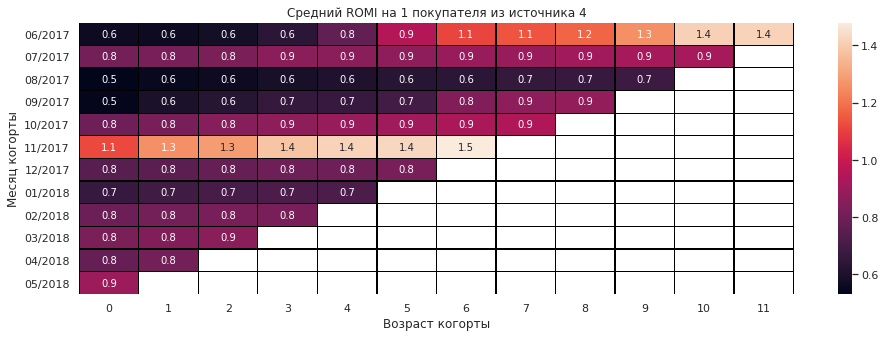

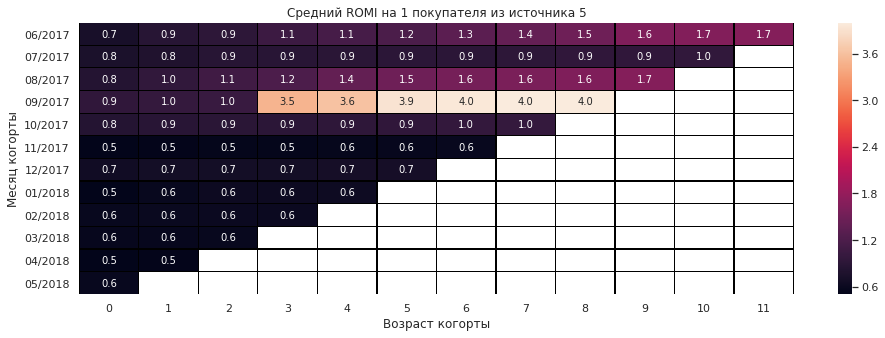

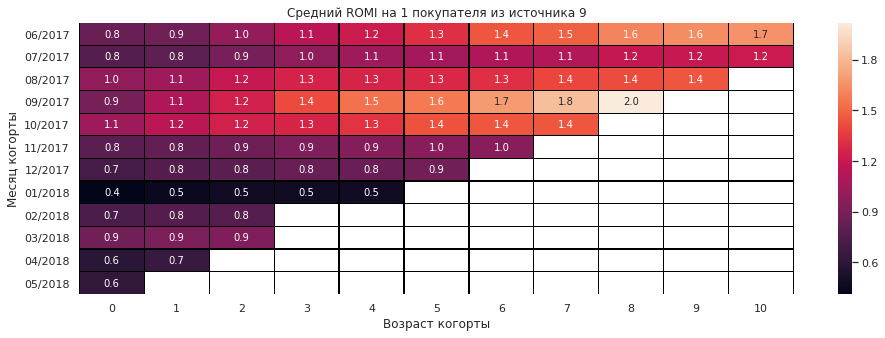

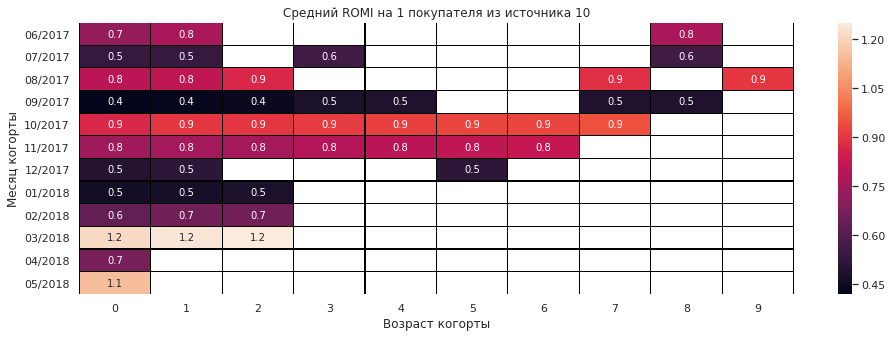

In [73]:
sources = romi_report_source['source_id'].unique()
 
for source in sources:
    plt.figure(figsize=(16, 5))
 
    romi_by_sources = (romi_report_source[romi_report_source['source_id'] == source]
              .pivot_table(index='first_order_month', columns='age', values='roi', aggfunc='mean'))
    
    romi_by_sources.index = romi_by_sources.index.strftime("%m/%Y")
 
    sns.heatmap(romi_by_sources.cumsum(axis=1).round(2), annot=True, fmt='.1f', linewidths=0.2, linecolor='black', annot_kws={"size": 10})
 
    plt.title('Средний ROMI на 1 покупателя из источника {}'.format(source))
    plt.xlabel('Возраст когорты')
    plt.ylabel('Месяц когорты')

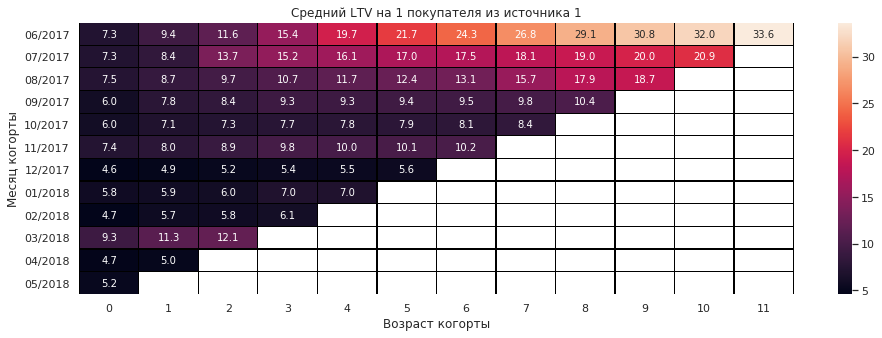

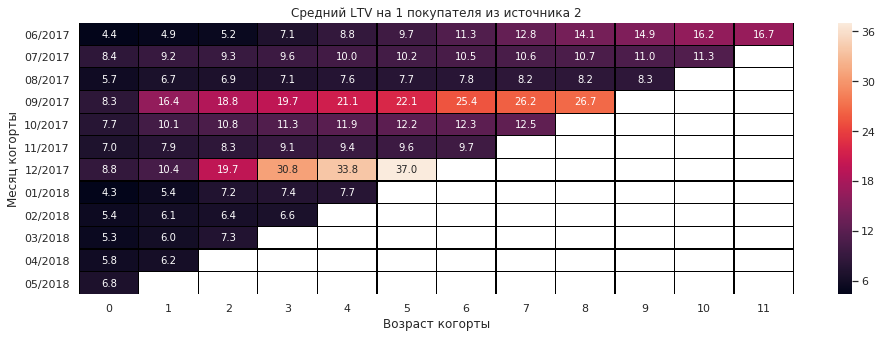

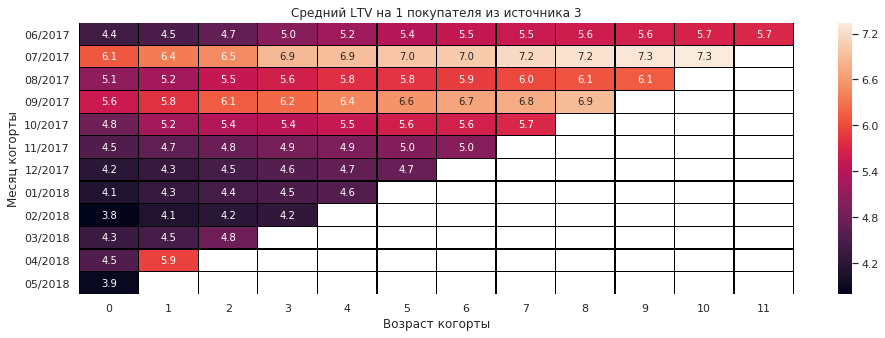

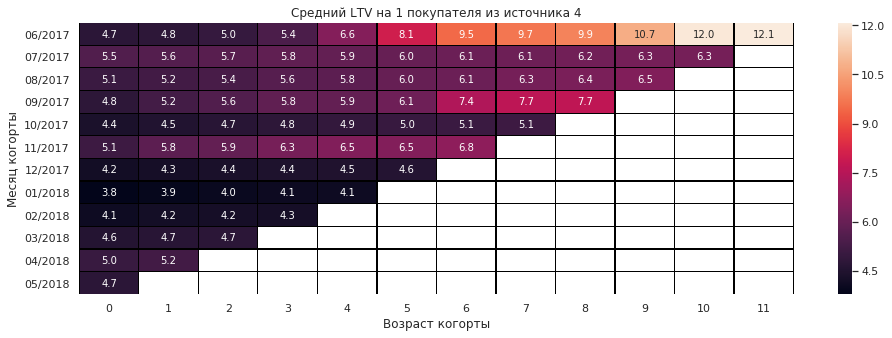

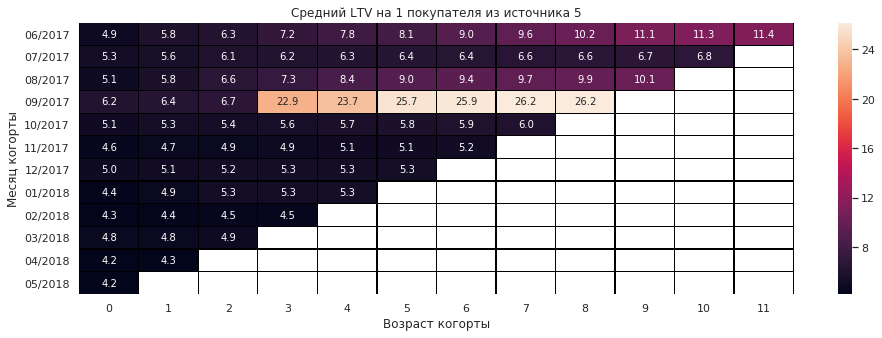

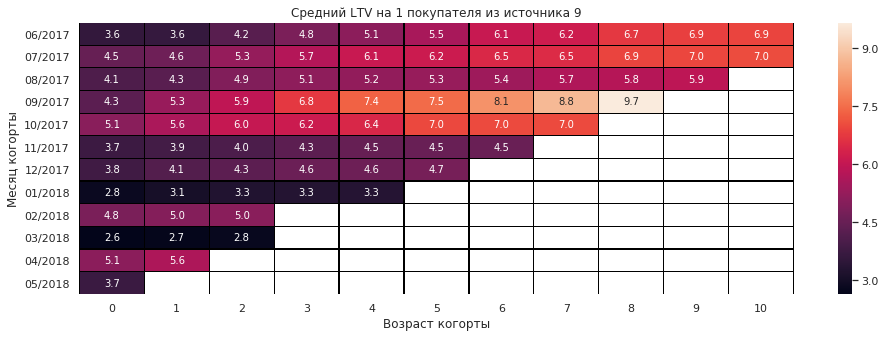

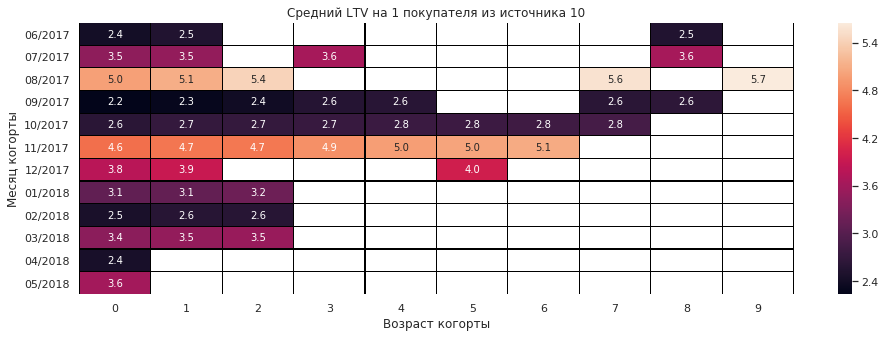

In [74]:
sources = romi_report_source['source_id'].unique()
 
for source in sources:
    plt.figure(figsize=(16, 5))
 
    romi_by_sources = (romi_report_source[romi_report_source['source_id'] == source]
              .pivot_table(index='first_order_month', columns='age', values='ltv', aggfunc='mean'))
    
    romi_by_sources.index = romi_by_sources.index.strftime("%m/%Y")
 
    sns.heatmap(romi_by_sources.cumsum(axis=1), annot=True, fmt='.1f', linewidths=0.2, linecolor='black', annot_kws={"size": 10})
 
    plt.title('Средний LTV на 1 покупателя из источника {}'.format(source))
    plt.xlabel('Возраст когорты')
    plt.ylabel('Месяц когорты')

In [75]:
def source_ltv_cohort(cohort): 
    df = romi_report_source.copy().query('source_id == @cohort')
    
    # проведем расчет всех метрик:
    df['ltv'] = df['revenue'] / df['uid']
    df['cac'] = df['costs'] / df['uid']
    df['roi'] = df['ltv'] / df['cac']
    
    # подготовим данные для тепловой карты по LTV:
    ltv = df.pivot_table(index='first_order_month', columns='age', values='ltv', aggfunc='mean')
    ltv.index = ltv.index.strftime("%m/%Y")

    # подготовим данные для тепловой карты по ROI:
    roi = df.pivot_table(index='first_order_month', columns='age', values='roi', aggfunc='mean')
    roi.index = roi.index.strftime("%m/%Y")

    # Построим графики:
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    fig.suptitle('LTV и ROMI метрики для источника №' + str(cohort))
    
    sns.heatmap(
        ltv.cumsum(axis=1),
        annot=True, 
        fmt='.1f', 
        linewidths=0.2, 
        linecolor='black',
        annot_kws={"size": 10},
        ax = axes[0]
    )

    sns.heatmap(
        roi.cumsum(axis=1),
        annot=True, 
        fmt='.1f', 
        linewidths=0.2, 
        linecolor='black',
        annot_kws={"size": 10},
        ax = axes[1]
    )
    
    axes[0].set_title('LTV')
    axes[1].set_title('ROMI')
    
    plt.show()

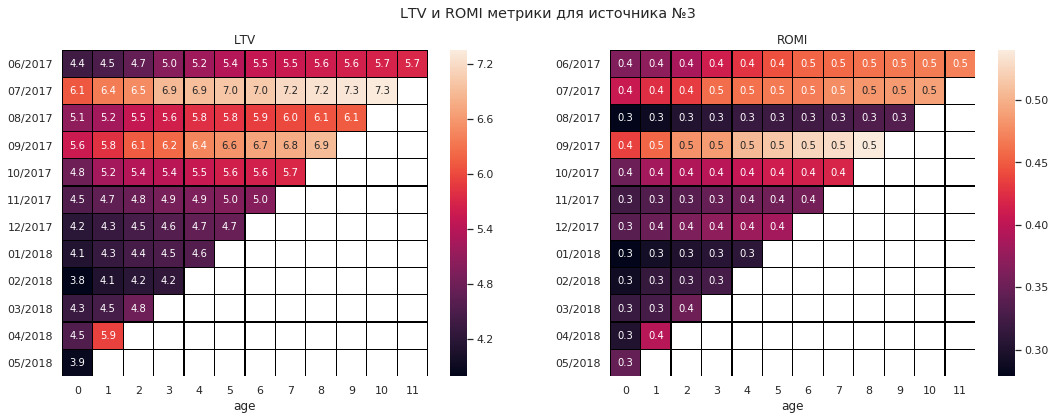

In [76]:
# посмотрим, что вышло:
source_ltv_cohort(3)

### Итог по Части 3.

1) Самые затратные источники это 3,4,5
    * Смотря на CAC 3 источник побеждает (он лидер среди источников)
    * Смотря на ROMI эти три источника не обладают какими-то осбенностями.
2) Затратные месяцы на маркетинг окзались осенние и зимние - они тесно сопряжены из-за Черной пятницы, предновогодней суеты и т.п. Уже в январе идет спад активности вложений.

3) Среди Когорт по ROMI 06.2017 и 09.2017 оказались лидерами.

4) В графике изменения во времени 1 источник также лидирует. 
    * интересен 5 источник в когорте 09.2017 на 4 месяце жизни набирает обороты.
5) Смотря на LTV интересны 1,2,5,9 источники, т.к. у них есть большие цифры в некоторые сезоны.
    * лидер 1 источник
    * Например, 2 источник подействовал на когорты 09.2017 (со 2 месяца) и 12. 2017 (с 3 месяца) + присутсвует рост в когорте 10.2017.
    * 5 источник хорошо подействовал на когорты 09.2017 - LTV с 3 месяца стал резко расти.
    * 9 источник в целом "лидер" среди слабых источников.
    
    

    

## ШАГ 3. Общий вывод.

1) Лучше использовать 1 и 2 рекламные источники - они условные лидеры (1 - самый успешный судя по ROMI).
    * 3 источник ест много, но приносит мало.
    * В целом нужно посмотреть и исследовать 2,3,4 источники - почему так мало приносят интереса, а едят много.    
    * Декабрь самый лакомый месяц - затраты на маркетинг высокие и средний чек не отстает.
* Ориентируемся на ROMI - т.к. более точно показал, проблемнсоть 3-4-5 источников    
    
    


2) Пробежимся по метрикам:
    * Продуктовые метрики:
        1. Высокая активность в ноябре-декабре-январе, далее идет спад (самая низкая точка это апрель) Летом июль активный месяц.
        2. В день в среднем бывает 987 сессий по 10 минут.
        3. По когортам - 1-ая самая высокая по рейтингу удержания. (на 12 месяц своего существования 4.50%)
        4. Средний Retention Rate на второй месяц «жизни» когорт равен: 1.1
    * Метрики электронной коммерции
        1. Покупают почти сразу как заходят ( в среденм показывает 249 минут, а в моде 1 минуту)
        2. Пользоваел соверашет 1.3. покупки в месяц
        3. среднее количество покупок на одного покупателя за 6 месяцев: 1.4
        4. Средний чек варьируется от 5 до 6. Среди временные показателей самые активные это ноябрь-декабрь-январь
        5. По LTV первые три когорты лидеры + 4 когорта с 4 месяца.
        6. Средний LTV по когортам за 6 месяцев равен: 8.0
    * Маркетинговые метрики:
        1. Всего на маркетинг потратили: 329131.6199999999
        2. Больше всего потратили на 3 источник, потом на 4 и 5
        3. Самые затраные месяцы осень-зима
        4. По CAC лидерство источников 3-2-5-1-4
        5. По ROMI 1 тип источника побеждает
            *  интересен 5 источник на 4 месяце жизни набирает обороты.
            * 3 источник остается непопулярным 

3) Когорты.
    * Нужно исследовать 1 и 4 когорты их LTV выглядят особенными в сравнении с другими.
    * Но также нужно опираться на 2 и 3 когорты их показатели LTV тоже достаточно сносны
        * Сюда же добавим 7 когорту - их показатели с 4 месяца довольно хороши
    * Что касается рейтинга удержания то интерес представляют первая когорта 100% (12 месяц 4.50%)
        * 4 когорта на второй месяц обладает рейтингом в 8.55% - это выше чем у первой (интересно с чем это связано).
    * По когортам ROMI также 1 и 4 когорты - почти одинаковы
        * 7 когорта тоже представляет интерес с 4 месяца.
        * не забываем о 2 и 3 когортах.